In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 5585, done.
remote: Counting objects: 100% (774/774), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 5585 (delta 663), reused 648 (delta 555), pack-reused 4811
Receiving objects: 100% (5585/5585), 2.87 GiB | 37.02 MiB/s, done.
Resolving deltas: 100% (4489/4489), done.
Updating files: 100% (485/485), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 1.0 MB/s eta 0:00:00


In [3]:
! pip install implicit

  Obtaining dependency information for implicit from https://files.pythonhosted.org/packages/cd/cc/deac70cae8cc32c9885d0cd73bc66e1b3cbea36ae7080b8c83995eaf5322/implicit-0.7.2-cp310-cp310-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 47.6 MB/s eta 0:00:00


In [4]:
! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorization_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorization_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorization_Cython_Epoch.c: In function ‘__pyx_pf_32MatrixFactorization

In [5]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps
import scipy.stats as stats
from concurrent.futures import ThreadPoolExecutor

from lightgbm import LGBMRanker

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv
/kaggle/input/training-tuned-models/als_all.npz
/kaggle/input/training-tuned-models/__results__.html
/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip
/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz
/kaggle/input/training-tuned-models/als_train_validation.npz
/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/slim_recall_train_validation.zip
/kaggle/input/training-tuned-models/__notebook__.ipynb
/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/ials_train_validation.zip
/kaggle/input/training-tuned-models/mult_vae_2_all.zip
/kaggle/input/training-tuned-models/__output__.json
/kaggle/input/training-tuned-models/ials_all.zip
/kaggle/input/training-tuned-models/slim_recall_xgboost_train

In [6]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [7]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender, SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender, PureSVDItemRecommender, ScaledPureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.SLIM.SLIM_BPR_Python import SLIM_BPR_Python
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender

from Recommenders.Hybrid.LinearCombinationRecommender import LinearCombinationRecommender
from Data_manager.CrossValidationSplitter import CrossValidationSplitter
from Recommenders.MatrixFactorization.ALSImplicitRecommender import ALSImplicitRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [8]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [9]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [10]:
config = {
    'tune_parameters': True,
    'n_trials': 50,
    'database_path': '/kaggle/working/tuning_hybrid_xgboost.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': True,
    'save_github': True
}

In [11]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [12]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [13]:
URM_train_complete, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_complete, train_percentage = 0.8)

In [14]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_item.json', 'r') as params_file:
    params_item_knn = json.load(params_file)
params_item_knn

{'topK': 14,
 'shrink': 25,
 'similarity': 'tversky',
 'tversky_alpha': 0.18163095712123836,
 'tversky_beta': 1.8529812241698465}

In [15]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_RP3.json', 'r') as params_file:
    params_rp3 = json.load(params_file)
params_rp3

{'alpha': 0.3408516511081212, 'beta': 0.1447198697205665, 'topK': 32}

In [16]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_user.json', 'r') as params_file:
    params_user_knn = json.load(params_file)
params_user_knn

{'topK': 498,
 'shrink': 0,
 'similarity': 'asymmetric',
 'asymmetric_alpha': 0.39792525383867455}

In [17]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_alpha.json', 'r') as params_file:
    params_p3alpha = json.load(params_file)
params_p3alpha

{'normalize_similarity': 'True',
 'implicit': 'True',
 'alpha': 0.29354071531607107,
 'topK': 49}

In [18]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_merging.json', 'r') as params_file:
    params_merging = json.load(params_file)
params_merging

{'alpha': 0.3375591188839621, 'topK': 86}

In [19]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_lr_comb_rp3_p3a_item.json', 'r') as params_file:
    params_lr_comb = json.load(params_file)
params_lr_comb

{'w1': 0.6982294749234325, 'w2': 0.9336649353144076, 'w3': 0.8685182329823133}

In [20]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/pure_svd_params.json', 'r') as params_file:
    params_pure_svd = json.load(params_file)
params_pure_svd

{'factors': 30}

In [21]:
# with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_item.json', 'r') as params_file:
#     params_pure_svd_item = json.load(params_file)
params_pure_svd_item = {"topK": 43, "num_factors": 171}

In [22]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_scaled.json', 'r') as params_file:
    params_scaled = json.load(params_file)
params_scaled

{'num_factors': 179,
 'scaling_items': 5.3298425368534826e-05,
 'scaling_users': 0.2791990262721904}

In [23]:
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip', 
    '/kaggle/working/ials_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_train_validation.zip', 
    '/kaggle/working/ials_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_all.zip', 
    '/kaggle/working/ials_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz', 
    '/kaggle/working/als_xgboost_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_train_validation.npz', 
    '/kaggle/working/als_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_all.npz', 
    '/kaggle/working/als_all.npz', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_xgboost_train_validation.zip', 
    '/kaggle/working/slim_recall_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_train_validation.zip', 
    '/kaggle/working/slim_recall_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_all.zip', 
    '/kaggle/working/slim_recall_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip', 
    '/kaggle/working/mult_vae_2_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip', 
    '/kaggle/working/mult_vae_2_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_all.zip', 
    '/kaggle/working/mult_vae_2_all.zip', 
)

'/kaggle/working/mult_vae_2_all.zip'

In [24]:
recommender_item = ItemKNNCFRecommender(URM_train)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_train = recommender_pure_svd.USER_factors
item_factors_train = recommender_pure_svd.ITEM_factors

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_xgboost_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_xgboost_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_xgboost_train_validation.zip')

recommender_slim_recall = SLIMElasticNetRecommender(URM_train)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_xgboost_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_xgboost_train_validation.zip')

recommender_ials = IALSRecommender(URM_train)
recommender_ials.load_model('/kaggle/working/', 'ials_xgboost_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_xgboost_train_validation')

# recommender_als = ALSImplicitRecommender(URM_train)
# recommender_als.load_model('/kaggle/working/', 'als_xgboost_train_validation.npz')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Similarity column 22347 (100.0%), 4777.19 column/sec. Elapsed time 4.68 sec
UserKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Similarity column 13024 (100.0%), 5161.20 column/sec. Elapsed time 2.52 sec
RP3betaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
RP3betaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2643.54 column/sec. Elapsed time 8.45 sec
P3alphaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
P3alphaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 3067.82 column/sec. Elapsed time 7.28 sec
PureSVDRecommender: URM Detected 851 ( 6.5%) users with no inter

In [25]:
evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions


In [26]:
print('Merging Models')
result_df, _ = evaluator.evaluateRecommender(hybrid_similarity)
display(result_df)
print('Item KNN')
result_df, _ = evaluator.evaluateRecommender(recommender_item)
display(result_df)
print('RP3 beta')
result_df, _ = evaluator.evaluateRecommender(recommender_rp3)
display(result_df)
print('P3 alpha')
result_df, _ = evaluator.evaluateRecommender(recommender_p3a)
display(result_df)
print('User KNN')
result_df, _ = evaluator.evaluateRecommender(recommender_user)
display(result_df)
print('NMF')
result_df, _ = evaluator.evaluateRecommender(recommender_nmf)
display(result_df)
print('Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_pure_svd)
display(result_df)
print('Scaled Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_scaled_svd)
display(result_df)
print('Item Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_pure_svd_item)
display(result_df)
print('SLIM BPR')
result_df, _ = evaluator.evaluateRecommender(recommender_slim_bpr)
display(result_df)
print('SLIM Elastic')
result_df, _ = evaluator.evaluateRecommender(recommender_slim)
display(result_df)
print('EASE R')
result_df, _ = evaluator.evaluateRecommender(recommender_ease_r)
display(result_df)
print('IALS')
result_df, _ = evaluator.evaluateRecommender(recommender_ials)
display(result_df)
print('MultVAE')
result_df, _ = evaluator.evaluateRecommender(recommender_vae)
display(result_df)
# print('ALS')
# result_df, _ = evaluator.evaluateRecommender(recommender_als)
# display(result_df)

Merging Models
EvaluatorHoldout: Processed 10456 (100.0%) in 9.12 sec. Users per second: 1146


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.081236,0.139185,0.117504,0.039511,0.068781,0.237517,0.127531,0.09606,0.475899,0.303733,...,0.802826,0.382064,0.802826,0.090882,10.724402,0.998438,0.265776,0.826934,1.502888,0.3873


Item KNN
EvaluatorHoldout: Processed 10456 (100.0%) in 9.33 sec. Users per second: 1120


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079227,0.134354,0.112913,0.038659,0.066899,0.232562,0.124152,0.093117,0.464327,0.297466,...,0.802826,0.372773,0.802826,0.075591,10.416934,0.997963,0.221058,0.803226,1.653431,0.383628


RP3 beta
EvaluatorHoldout: Processed 10456 (100.0%) in 9.04 sec. Users per second: 1157


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079658,0.136429,0.115204,0.038171,0.066535,0.231172,0.124353,0.094189,0.47303,0.294753,...,0.802826,0.37976,0.802826,0.096602,10.808804,0.998526,0.282504,0.833442,1.437561,0.390783


P3 alpha
EvaluatorHoldout: Processed 10456 (100.0%) in 8.86 sec. Users per second: 1180


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.076664,0.128535,0.10787,0.037284,0.064338,0.227507,0.119981,0.089628,0.456676,0.289145,...,0.802826,0.366631,0.802826,0.072251,10.504764,0.998262,0.21129,0.809998,1.371811,0.386528


User KNN
EvaluatorHoldout: Processed 10456 (100.0%) in 12.55 sec. Users per second: 833


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.061448,0.112121,0.096632,0.028523,0.05183,0.190388,0.099346,0.075124,0.40637,0.231987,...,0.802826,0.326244,0.802826,0.011369,7.734762,0.986162,0.033249,0.59641,3.662908,0.323456


NMF
EvaluatorHoldout: Processed 10456 (100.0%) in 12.46 sec. Users per second: 839


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.051415,0.084267,0.069573,0.024792,0.040821,0.165486,0.079928,0.059132,0.338849,0.201455,...,0.802826,0.272036,0.802826,0.018774,9.145243,0.997874,0.054903,0.705169,1.326454,0.362589


Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 11.49 sec. Users per second: 910


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.05022,0.086014,0.072432,0.023883,0.040909,0.164475,0.080074,0.059315,0.344109,0.197553,...,0.802826,0.276259,0.802826,0.005554,7.368601,0.992223,0.016243,0.568176,2.711888,0.326934


Scaled Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 15.23 sec. Users per second: 687


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.052802,0.090327,0.076977,0.025086,0.043651,0.170985,0.084357,0.062638,0.35635,0.206245,...,0.802826,0.286087,0.802826,0.013232,8.625793,0.996729,0.038694,0.665115,1.992554,0.343623


Item Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 13.98 sec. Users per second: 748


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.053395,0.088783,0.074181,0.025534,0.042764,0.173646,0.083816,0.062095,0.355777,0.20946,...,0.802826,0.285627,0.802826,0.018466,9.043891,0.997531,0.054003,0.697354,1.425533,0.361464


SLIM BPR
EvaluatorHoldout: Processed 10456 (100.0%) in 10.46 sec. Users per second: 1000


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.057154,0.100577,0.085625,0.026561,0.047843,0.179969,0.091756,0.068551,0.382269,0.217765,...,0.802826,0.306895,0.802826,0.030224,8.973277,0.994651,0.088387,0.691909,2.634383,0.346626


SLIM Elastic
EvaluatorHoldout: Processed 10456 (100.0%) in 12.41 sec. Users per second: 842


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079839,0.135985,0.114694,0.038588,0.0664,0.233862,0.124583,0.094144,0.472743,0.298541,...,0.802826,0.37953,0.802826,0.053029,10.313128,0.998528,0.155077,0.795222,1.619657,0.371056


EASE R
EvaluatorHoldout: Processed 10456 (100.0%) in 13.31 sec. Users per second: 786


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.07523,0.130395,0.110728,0.036193,0.063731,0.2264,0.119463,0.089591,0.46031,0.284432,...,0.802826,0.369549,0.802826,0.030039,9.477048,0.99708,0.087846,0.730753,2.146813,0.353406


IALS
EvaluatorHoldout: Processed 10456 (100.0%) in 19.22 sec. Users per second: 544


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.069539,0.122979,0.105423,0.032759,0.05783,0.209923,0.11029,0.083801,0.437835,0.260966,...,0.802826,0.351505,0.802826,0.024802,9.523511,0.998258,0.072532,0.734336,1.744761,0.356885


MultVAE
EvaluatorHoldout: Processed 10456 (100.0%) in 24.72 sec. Users per second: 423


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.066115,0.123357,0.107416,0.029619,0.054903,0.197963,0.106087,0.081851,0.435731,0.241465,...,0.802826,0.349816,0.802826,0.016447,7.902069,0.982289,0.048098,0.60931,3.855345,0.321449


In [27]:
cutoff = 50
n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    if user_id == 0:
        print(recommendations)
    training_dataframe.loc[user_id, "ItemID"] = recommendations
    
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

/tmp/ipykernel_20/3291901882.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

[35, 100, 505, 428, 591, 693, 402, 1480, 122, 617, 976, 868, 3, 514, 111, 2, 636, 1545, 256, 341, 336, 1629, 101, 9, 84, 1, 0, 1421, 849, 1287, 1934, 1082, 1213, 53, 28, 288, 1056, 57, 76, 75, 921, 86, 1337, 2498, 772, 136, 283, 533, 97, 155]


,ItemID
UserID,
0,35
0,100
0,505
0,428
0,591
...,...
13023,170
13023,605
13023,6214


In [28]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,15
1,0,385
2,0,1934
3,0,4302
4,0,17444
...,...,...
76592,13023,2365
76593,13023,2961
76594,13023,3606
76595,13023,6282


In [29]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,35,False
1,0,100,False
2,0,505,False
3,0,428,False
4,0,591,False
...,...,...,...
651195,13023,170,False
651196,13023,605,True
651197,13023,6214,False
651198,13023,1373,False


In [30]:
training_dataframe.Label.sum()

15808

In [31]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    # 'ALS': recommender_als
}

In [32]:
tmp = training_dataframe[training_dataframe['UserID'] == 0].copy()

scores = recommender_item._compute_item_score([0])
linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
linf_scores[0, :] = recommender_item._remove_seen_on_scores(0, linf_scores[0, :])
linf_scores

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [33]:
rank = np.argsort(linf_scores[0, :])[::-1]
rank[:50]

array([  35,  100,  505,  591,  693, 1480,  402,  617,  341,  122, 1421,
       1545,  428, 1082, 1287, 1337, 1213, 1088,  170,  138,  253, 1131,
       3156, 1056,  215, 3728,  514,  101, 2724, 1629,  485, 1913, 1257,
        772,   75, 4499,  385, 2539,  492,  636, 4749, 1934, 2480,  849,
       1813,  155, 2002, 1514,  976,  699])

In [34]:
tmp.ItemID.values.astype(int)

array([  35,  100,  505,  428,  591,  693,  402, 1480,  122,  617,  976,
        868,    3,  514,  111,    2,  636, 1545,  256,  341,  336, 1629,
        101,    9,   84,    1,    0, 1421,  849, 1287, 1934, 1082, 1213,
         53,   28,  288, 1056,   57,   76,   75,  921,   86, 1337, 2498,
        772,  136,  283,  533,   97,  155])

In [35]:
item_list = tmp.ItemID.values.astype(int)

positions = np.zeros(n_items, dtype=int)
positions[rank] = np.arange(n_items)
positions[item_list]

array([    0,     1,     2,    12,     3,     4,     6,     5,     9,
           7,    48,  8149,  7494,    26,    50,  7493,    39,    11,
        7688,     8,  7638,    29,    27,  7499,  7528,  7492, 21981,
          10,    43,    14,    41,    13,    16,  7541,  7474,  7590,
          23,  7545,  7520,    34,    60,  7530,    15,  6457,    33,
        7424,  7585,  7088,  7411,    45])

In [36]:
recommended = np.isin(item_list, rank[:10], assume_unique=True)
recommended.astype(int)

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [37]:
training_dataframe = training_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        training_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        training_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        training_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()

item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        training_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[training_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        training_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        training_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        training_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        training_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        training_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[training_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        training_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        training_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        training_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        training_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        training_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

# todo: cluster if possible the similarity matrix of KNN or RP3, then add for each users some features 
# that represent something like users that like only items from the same cluster (e.g. items variability)
# same can be done with users and items reversed (i.e. using User KNN)

recommended_columns = [col for col in training_dataframe.columns if col.endswith('_Recommended')]
training_dataframe['Counter_Recommended'] = training_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in training_dataframe.columns if col.endswith('_RankPosition')]
training_dataframe['Mean_RankPosition'] = training_dataframe[position_columns].mean(axis=1)
training_dataframe['Std_RankPosition'] = training_dataframe[position_columns].std(axis=1)
training_dataframe['Skew_RankPosition'] = training_dataframe[position_columns].skew(axis=1)
training_dataframe['Kurtosis_RankPosition'] = training_dataframe[position_columns].kurtosis(axis=1)

# todo: weighted score makes sense? Same features of position but for score might be not useful
# since ranges are different

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_20/2167912425.py:39: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
/tmp/ipykernel_20/2167912425.py:40: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)


  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,MaxSimilarityToSeenRP3,MinSimilarityToSeenRP3,StdSimilarityToSeenRP3,SkewSimilarityToSeenRP3,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition
0,0,35,False,0.771709,0.0,1.0,0.010529,165.0,0.0,0.804430,...,0.092288,0.0,0.017127,5.003698,23.036989,11,14.461538,45.437898,3.550564,12.697736
1,0,100,False,0.550739,1.0,1.0,0.010197,166.0,0.0,0.551174,...,0.086162,0.0,0.018270,3.696277,12.423644,12,13.230769,45.904164,3.604793,12.996074
2,0,505,False,0.524022,2.0,1.0,0.063451,58.0,0.0,0.354394,...,0.073953,0.0,0.018064,2.531372,5.318754,12,7.076923,15.353944,3.562237,12.769450
3,0,428,False,0.242514,12.0,0.0,0.005722,180.0,0.0,0.167343,...,0.067306,0.0,0.019153,1.729575,1.577202,5,30.692308,48.104720,2.868017,8.957892
4,0,591,False,0.513606,3.0,1.0,0.069904,43.0,0.0,0.260866,...,0.082681,0.0,0.015344,5.003704,23.037041,6,68.153846,131.605374,2.634255,7.000376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651195,13023,170,False,0.068760,73.0,0.0,0.381633,5.0,1.0,0.081454,...,0.041414,0.0,0.006039,6.559126,41.022152,2,60.000000,42.634102,0.441703,-0.670449
651196,13023,605,True,0.057563,100.0,0.0,0.203670,56.0,0.0,0.061681,...,0.059903,0.0,0.008736,6.559142,41.022297,3,52.230769,41.342379,0.440308,-0.859601
651197,13023,6214,False,0.114844,39.0,0.0,0.153297,100.0,0.0,0.252423,...,0.036249,0.0,0.009074,2.990309,7.077977,1,263.538462,452.875004,2.874296,9.014118
651198,13023,1373,False,0.056598,102.0,0.0,0.234818,36.0,0.0,0.000000,...,0.039994,0.0,0.005832,6.559140,41.022385,0,1278.692308,2982.912178,2.178514,3.224866


In [38]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)
item_popularity = item_popularity / np.max(item_popularity)
training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)
user_popularity = user_popularity / np.max(user_popularity)
training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
training_dataframe['mainstream_user'] = mainstream_user[training_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
training_dataframe['mainstream_item'] = mainstream_item[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition,item_popularity,user_profile_len,mainstream_user,mainstream_item
0,0,35,False,0.771709,0.0,1.0,0.010529,165.0,0.0,0.804430,...,23.036989,11,14.461538,45.437898,3.550564,12.697736,0.411713,0.033573,77.384713,77.185358
1,0,100,False,0.550739,1.0,1.0,0.010197,166.0,0.0,0.551174,...,12.423644,12,13.230769,45.904164,3.604793,12.996074,0.232476,0.033573,77.384713,90.053545
2,0,505,False,0.524022,2.0,1.0,0.063451,58.0,0.0,0.354394,...,5.318754,12,7.076923,15.353944,3.562237,12.769450,0.079858,0.033573,77.384713,102.144698
3,0,428,False,0.242514,12.0,0.0,0.005722,180.0,0.0,0.167343,...,1.577202,5,30.692308,48.104720,2.868017,8.957892,0.044366,0.033573,77.384713,97.835492
4,0,591,False,0.513606,3.0,1.0,0.069904,43.0,0.0,0.260866,...,23.037041,6,68.153846,131.605374,2.634255,7.000376,0.086069,0.033573,77.384713,86.651586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651195,13023,170,False,0.068760,73.0,0.0,0.381633,5.0,1.0,0.081454,...,41.022152,2,60.000000,42.634102,0.441703,-0.670449,0.173026,0.055156,53.265190,98.486897
651196,13023,605,True,0.057563,100.0,0.0,0.203670,56.0,0.0,0.061681,...,41.022297,3,52.230769,41.342379,0.440308,-0.859601,0.079858,0.055156,53.265190,94.862590
651197,13023,6214,False,0.114844,39.0,0.0,0.153297,100.0,0.0,0.252423,...,7.077977,1,263.538462,452.875004,2.874296,9.014118,0.011535,0.055156,53.265190,169.226711
651198,13023,1373,False,0.056598,102.0,0.0,0.234818,36.0,0.0,0.000000,...,41.022385,0,1278.692308,2982.912178,2.178514,3.224866,0.047915,0.055156,53.265190,112.935230


In [39]:
user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])

training_dataframe = training_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
training_dataframe = training_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
training_dataframe = training_dataframe.sort_values(by='UserID')
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,35,False,0.771709,0.0,1.0,0.010529,165.0,0.0,0.804430,...,0.070908,0.005731,0.083522,-0.090610,0.014975,0.005684,-0.001896,0.008995,-0.013853,-0.002147
27,0,1421,False,0.273926,10.0,0.0,0.000823,580.0,0.0,0.137874,...,0.008304,-0.000813,0.007862,-0.005303,0.004007,0.005684,-0.001896,0.008995,-0.013853,-0.002147
28,0,849,False,0.109069,43.0,0.0,0.002299,237.0,0.0,0.063939,...,0.007942,-0.005888,0.008819,-0.006112,0.006760,0.005684,-0.001896,0.008995,-0.013853,-0.002147
29,0,1287,False,0.228756,14.0,0.0,0.068837,46.0,0.0,0.125857,...,0.008537,-0.009985,0.006478,0.003883,-0.011649,0.005684,-0.001896,0.008995,-0.013853,-0.002147
30,0,1934,True,0.111270,41.0,0.0,0.033073,104.0,0.0,0.061394,...,0.005471,0.001350,0.008471,-0.005479,0.002262,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651193,13023,389,False,0.054072,106.0,0.0,0.059093,621.0,0.0,0.086976,...,0.011188,-0.017740,-0.005322,-0.011841,-0.004538,0.006896,-0.007143,0.001571,0.006195,0.023549
651176,13023,2195,False,0.096075,48.0,0.0,0.219686,48.0,0.0,0.049547,...,0.004869,-0.011313,0.006562,-0.000144,0.018232,0.006896,-0.007143,0.001571,0.006195,0.023549
651189,13023,180,False,0.093238,53.0,0.0,0.026436,2196.0,0.0,0.096624,...,0.028602,-0.007037,-0.013733,0.010851,-0.019142,0.006896,-0.007143,0.001571,0.006195,0.023549
651170,13023,349,False,0.129561,30.0,0.0,0.353050,8.0,1.0,0.167004,...,0.023461,-0.039074,0.033606,0.036253,0.073695,0.006896,-0.007143,0.001571,0.006195,0.023549


In [40]:
n_estimators = 500
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
num_leaves = 32
objective = "lambdarank"
boosting_type = "gbdt"
use_user_profile = False
random_seed = None

LGBM_model = LGBMRanker(
    objective = objective,
    n_estimators = int(n_estimators),
    random_state = random_seed,
    learning_rate = learning_rate,
    reg_alpha = reg_alpha,
    reg_lambda = reg_lambda,
    max_depth = int(max_depth),
    num_leaves = int(num_leaves),
    boosting_type = boosting_type,
)

In [41]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([50, 50, 50, ..., 50, 50, 50])

In [42]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])
# X_train["UserID"] = X_train["UserID"].astype("category")
# X_train["ItemID"] = X_train["ItemID"].astype("category")
X_train["UserID"] = X_train["UserID"].astype(int)
X_train["ItemID"] = X_train["ItemID"].astype(int)

# object_columns = X_train.select_dtypes(include=['object']).columns
# X_train[object_columns] = X_train[object_columns].astype('category')

LGBM_model.fit(
    X_train,
    y_train,
    group=groups,
)

LGBMRanker(max_depth=5, n_estimators=500, num_leaves=32, objective='lambdarank',
           reg_alpha=0.1, reg_lambda=0.1)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='Feature importance', ylabel='Features'>

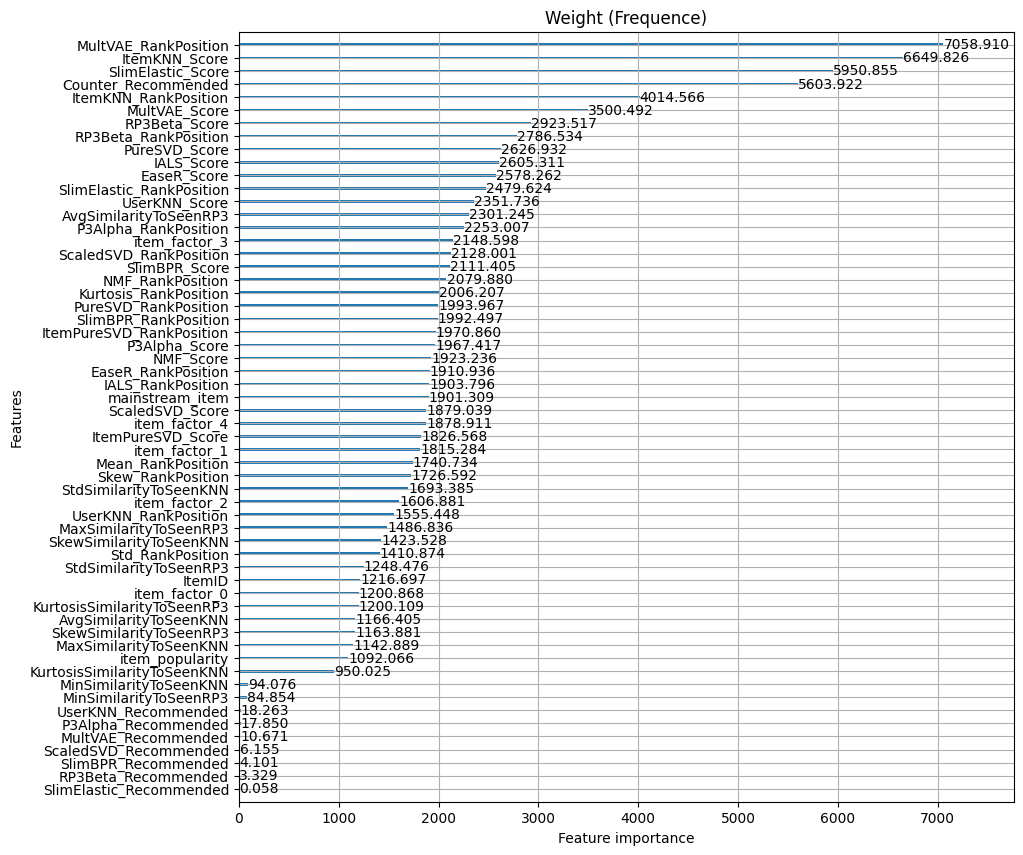

In [43]:
from lightgbm import plot_importance

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(LGBM_model, importance_type='gain', title='Weight (Frequence)', ax=ax)

In [44]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train_complete)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_train_validation')

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train_complete, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 22347 (100.0%), 4389.87 column/sec. Elapsed time 5.09 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4643.43 column/sec. Elapsed time 2.80 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2277.65 column/sec. Elapsed time 9.81 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 2916.86 column/sec. Elapsed time 7.66 sec
PureSVDRecommender: URM Detected 627 ( 4.8%) users with no inter

In [45]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    # 'ALS': recommender_als
}

In [46]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

validation_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
validation_dataframe.index.name='UserID'

for user_id in tqdm.auto.tqdm(range(n_users)):    
    recommendations = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    validation_dataframe.loc[user_id, "ItemID"] = recommendations
    
validation_dataframe = validation_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = validation_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        validation_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        validation_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        validation_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[validation_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        validation_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        validation_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[validation_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        validation_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        validation_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()
    
validation_dataframe = validation_dataframe.reset_index()
validation_dataframe = validation_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in validation_dataframe.columns if col.endswith('_Recommended')]
validation_dataframe['Counter_Recommended'] = validation_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in validation_dataframe.columns if col.endswith('_RankPosition')]
validation_dataframe['Mean_RankPosition'] = validation_dataframe[position_columns].mean(axis=1)
validation_dataframe['Std_RankPosition'] = validation_dataframe[position_columns].std(axis=1)
validation_dataframe['Skew_RankPosition'] = validation_dataframe[position_columns].skew(axis=1)
validation_dataframe['Kurtosis_RankPosition'] = validation_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
validation_dataframe['item_popularity'] = item_popularity[validation_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
validation_dataframe['user_profile_len'] = user_popularity[validation_dataframe["UserID"].values.astype(int)]
validation_dataframe

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_20/3726329592.py:49: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  validation_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
/tmp/ipykernel_20/3726329592.py:50: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)


  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,StdSimilarityToSeenRP3,SkewSimilarityToSeenRP3,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition,item_popularity,user_profile_len
0,0,35,0.942964,0.0,1.0,0.037371,41.0,0.0,0.999998,0.0,...,0.018748,5.003693,23.036957,10,5.076923,11.521440,2.942148,9.168774,0.406406,0.032075
1,0,100,0.830547,1.0,1.0,0.033586,45.0,0.0,0.744487,1.0,...,0.018819,3.772862,13.105057,12,4.076923,12.304888,3.596127,12.951546,0.237011,0.032075
2,0,505,0.471617,3.0,1.0,0.015319,49.0,0.0,0.288312,3.0,...,0.016424,2.626812,5.960841,12,7.769231,12.597314,3.403771,11.922829,0.074733,0.032075
3,0,51,0.213902,19.0,0.0,0.004863,159.0,0.0,0.111361,14.0,...,0.000000,NaN,NaN,6,34.153846,62.344268,2.150290,3.333856,0.202135,0.032075
4,0,402,0.598366,2.0,1.0,0.013870,50.0,0.0,0.283639,4.0,...,0.013440,3.071784,8.519635,9,10.153846,14.229349,2.275056,5.063534,0.074021,0.032075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651195,13023,242,0.094612,59.0,0.0,0.059399,687.0,0.0,0.057316,77.0,...,0.000000,NaN,NaN,2,117.307692,192.883983,2.601152,6.877059,0.113879,0.056604
651196,13023,852,0.056650,89.0,0.0,0.338165,19.0,0.0,0.000000,8068.0,...,0.000000,NaN,NaN,0,1288.307692,3018.009758,2.178100,3.221650,0.054093,0.056604
651197,13023,963,0.065047,80.0,0.0,0.304115,24.0,0.0,0.000000,8325.0,...,0.005985,6.559123,41.022182,0,752.846154,2283.326625,3.561836,12.762029,0.054804,0.056604
651198,13023,11955,0.260745,15.0,0.0,0.157063,126.0,0.0,0.138857,32.0,...,0.014879,2.872438,6.805297,0,219.384615,401.905158,2.519290,6.031258,0.004982,0.056604


In [47]:
mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
validation_dataframe['mainstream_user'] = mainstream_user[validation_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
validation_dataframe['mainstream_item'] = mainstream_item[validation_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])
validation_dataframe = validation_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
validation_dataframe = validation_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
validation_dataframe = validation_dataframe.sort_values(by='UserID')

validation_dataframe

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,35,0.942964,0.0,1.0,0.037371,41.0,0.0,0.999998,0.0,...,0.070908,0.005731,0.083522,-0.090610,0.014975,0.005684,-0.001896,0.008995,-0.013853,-0.002147
27,0,86,0.000000,7533.0,0.0,0.008853,70.0,0.0,0.000000,7509.0,...,0.052802,0.039735,0.028306,-0.087907,-0.017382,0.005684,-0.001896,0.008995,-0.013853,-0.002147
28,0,1082,0.261194,14.0,0.0,0.003559,265.0,0.0,0.101984,16.0,...,0.008902,-0.013901,0.005310,0.008307,0.003830,0.005684,-0.001896,0.008995,-0.013853,-0.002147
29,0,636,0.099262,55.0,0.0,0.008037,80.0,0.0,0.094083,21.0,...,0.009434,0.000249,0.008939,-0.006449,0.002131,0.005684,-0.001896,0.008995,-0.013853,-0.002147
30,0,1337,0.256143,15.0,0.0,0.002795,372.0,0.0,0.077940,33.0,...,0.007159,-0.012959,0.016733,0.007981,0.040655,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651197,13023,963,0.065047,80.0,0.0,0.304115,24.0,0.0,0.000000,8325.0,...,0.012389,-0.028209,0.014298,-0.001750,0.041015,0.006896,-0.007143,0.001571,0.006195,0.023549
651194,13023,14,0.000000,7520.0,0.0,0.137722,155.0,0.0,0.000000,7480.0,...,0.095542,0.015748,0.113690,-0.135039,0.018867,0.006896,-0.007143,0.001571,0.006195,0.023549
651153,13023,732,0.467619,5.0,1.0,0.567250,0.0,1.0,0.406934,8.0,...,0.014192,-0.031852,0.012810,0.008754,0.044532,0.006896,-0.007143,0.001571,0.006195,0.023549
651154,13023,324,0.234817,19.0,0.0,0.461441,2.0,1.0,0.229530,16.0,...,0.023976,-0.045454,0.032942,0.022102,0.076070,0.006896,-0.007143,0.001571,0.006195,0.023549


In [48]:
# validation_dataframe["UserID"] = validation_dataframe["UserID"].astype("category")
# validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype("category")

validation_dataframe["UserID"] = validation_dataframe["UserID"].astype(int)
validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype(int)

# object_columns = validation_dataframe.select_dtypes(include=['object']).columns
# validation_dataframe[object_columns] = validation_dataframe[object_columns].astype('category')

In [49]:
class LightGBMRerankerRecommender:
    def __init__(self, URM_train, XGB_model, df):
        self.URM_train = URM_train
        self.df = df
        self.XGB_model = XGB_model
        
    def recommend(self, user_ids, cutoff=10, return_scores=True, remove_seen_flag=True, remove_top_pop_flag=True, remove_custom_items_flag=False):
        recommendations = []
        for user_id in user_ids:
            df_slice = self.df[self.df['UserID'] == user_id]
            items = df_slice.ItemID.to_numpy()
            preds = self.XGB_model.predict(df_slice)
            recommendations.append(items[np.argsort(preds)[-cutoff:][::-1]].tolist())
            
        if return_scores:
            rec, scores = recommender_item.recommend(user_ids, cutoff=cutoff, return_scores=return_scores)
            # useless scores
            return np.array(recommendations), scores
        return np.array(recommendations)
    
    def get_URM_train(self):
        return self.URM_train

In [50]:
recommender = LightGBMRerankerRecommender(URM_train_complete, LGBM_model, validation_dataframe)
result_df, _ = evaluator.evaluateRecommender(recommender)
result_df

EvaluatorHoldout: Processed 10456 (100.0%) in 58.19 sec. Users per second: 180


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.093841,0.162578,0.137476,0.045471,0.076512,0.254366,0.143052,0.111543,0.522188,0.336289,...,0.802826,0.419226,0.802826,0.043572,9.83165,0.996548,0.125723,0.757392,2.160281,0.288475


In [51]:
def objective_xgboost(trial):

    LGBM_model = LGBMRanker(
        objective = trial.suggest_categorical('objective', ["lambdarank", "rank_xendcg"]),
        n_estimators = trial.suggest_int('n_estimators', 10, 5000, log=True),
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.5, log=True),
        reg_alpha = trial.suggest_float('reg_alpha', 1e-5, 1, log=True),
        reg_lambda = trial.suggest_float('reg_lambda', 1e-5, 1, log=True),
        max_depth = trial.suggest_int('max_depth', 3, 20),
        num_leaves = trial.suggest_int('num_leaves', 8, 1024),
        boosting_type = "gbdt",
        min_split_gain = trial.suggest_float('min_split_gain', 1e-7, 10, log=True),
        min_child_weight = trial.suggest_float('min_child_weight', 1e-7, 1, log=True),
        min_child_samples = trial.suggest_int('min_child_samples', 5, 200),
        subsample = trial.suggest_float('subsample', 0.1, 0.9),
        subsample_freq = trial.suggest_int('subsample_freq', 1, 20),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 0.9)
    )
    
    LGBM_model.fit(
        X_train,
        y_train,
        group=groups,
    )
    
    recommender = LightGBMRerankerRecommender(URM_train_complete, LGBM_model, validation_dataframe)
    result_df, _ = evaluator.evaluateRecommender(recommender)
        
    return result_df.loc[10, 'MAP']

In [52]:
try:
    shutil.copyfile(
        '/kaggle/working/Recsys_Challenge_2023/tuning_results/tuning_hybrid_lightgbm.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass

In [53]:
if config['tune_parameters']:
    study = optuna.create_study(direction='maximize', study_name='lightgbm_tuning_v2', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_xgboost, n_trials=config['n_trials'])

[I 2023-12-23 12:31:38,283] Using an existing study with name 'lightgbm_tuning_v2' instead of creating a new one.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.51 min. Users per second: 115


[I 2023-12-23 12:36:13,662] Trial 50 finished with value: 0.051582625909328814 and parameters: {'objective': 'lambdarank', 'n_estimators': 438, 'learning_rate': 0.00036452244382196517, 'reg_alpha': 1.0128947728269264e-05, 'reg_lambda': 0.00344884454068171, 'max_depth': 16, 'num_leaves': 450, 'min_split_gain': 3.671419114924269e-05, 'min_child_weight': 0.03287508300060408, 'min_child_samples': 32, 'subsample': 0.886901128355894, 'subsample_freq': 20, 'colsample_bytree': 0.2913269046832899}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.59 min. Users per second: 109


[I 2023-12-23 12:39:47,373] Trial 51 finished with value: 0.051836011980666355 and parameters: {'objective': 'lambdarank', 'n_estimators': 486, 'learning_rate': 0.0005123884986935508, 'reg_alpha': 0.00018217493737020127, 'reg_lambda': 0.0017417012734838304, 'max_depth': 18, 'num_leaves': 263, 'min_split_gain': 7.50966827519818e-05, 'min_child_weight': 0.043176354011608686, 'min_child_samples': 17, 'subsample': 0.861123675463136, 'subsample_freq': 17, 'colsample_bytree': 0.11501429974640649}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.61 min. Users per second: 108


[I 2023-12-23 12:43:57,843] Trial 52 finished with value: 0.05124430721026042 and parameters: {'objective': 'lambdarank', 'n_estimators': 600, 'learning_rate': 0.00038967126186480595, 'reg_alpha': 8.61230954630258e-05, 'reg_lambda': 0.002015971194275709, 'max_depth': 15, 'num_leaves': 323, 'min_split_gain': 3.7231666709574914e-05, 'min_child_weight': 0.19223095080457822, 'min_child_samples': 16, 'subsample': 0.8115652092723011, 'subsample_freq': 18, 'colsample_bytree': 0.1010497077218143}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.39 min. Users per second: 73


[I 2023-12-23 12:51:38,075] Trial 53 finished with value: 0.05183683933277518 and parameters: {'objective': 'lambdarank', 'n_estimators': 931, 'learning_rate': 0.00023333448753274223, 'reg_alpha': 0.00016066407725072205, 'reg_lambda': 0.004943475487385792, 'max_depth': 13, 'num_leaves': 415, 'min_split_gain': 0.0001998759870835183, 'min_child_weight': 0.06542177517605596, 'min_child_samples': 6, 'subsample': 0.8386051489164852, 'subsample_freq': 19, 'colsample_bytree': 0.19423288478562228}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.34 min. Users per second: 52


[I 2023-12-23 13:01:44,434] Trial 54 finished with value: 0.05184423236905128 and parameters: {'objective': 'lambdarank', 'n_estimators': 1542, 'learning_rate': 0.00031918589458982565, 'reg_alpha': 8.911672036290474e-05, 'reg_lambda': 0.01034770507597289, 'max_depth': 17, 'num_leaves': 276, 'min_split_gain': 0.001134990682296053, 'min_child_weight': 0.012225327759001049, 'min_child_samples': 24, 'subsample': 0.8762469569395135, 'subsample_freq': 18, 'colsample_bytree': 0.13934902152365045}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.07 min. Users per second: 84


[I 2023-12-23 13:08:37,047] Trial 55 finished with value: 0.051711977477806245 and parameters: {'objective': 'lambdarank', 'n_estimators': 818, 'learning_rate': 0.00014000180920862277, 'reg_alpha': 5.052379045805402e-05, 'reg_lambda': 0.01550704711632985, 'max_depth': 19, 'num_leaves': 392, 'min_split_gain': 7.225925590871153e-05, 'min_child_weight': 0.005407484808971957, 'min_child_samples': 47, 'subsample': 0.7830088794521081, 'subsample_freq': 15, 'colsample_bytree': 0.2320209139136679}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.71 min. Users per second: 102


[I 2023-12-23 13:13:22,607] Trial 56 finished with value: 0.051746521325949923 and parameters: {'objective': 'lambdarank', 'n_estimators': 514, 'learning_rate': 0.0005754097334115563, 'reg_alpha': 0.00028465331600550323, 'reg_lambda': 0.008066853706703115, 'max_depth': 13, 'num_leaves': 527, 'min_split_gain': 0.00034912380015894237, 'min_child_weight': 0.02650861213494882, 'min_child_samples': 57, 'subsample': 0.7261653424170776, 'subsample_freq': 20, 'colsample_bytree': 0.16250094717250593}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-23 13:19:07,534] Trial 57 finished with value: 0.05191111505811255 and parameters: {'objective': 'lambdarank', 'n_estimators': 687, 'learning_rate': 0.00019483400029557458, 'reg_alpha': 0.00016125939485912822, 'reg_lambda': 0.0007480715727248374, 'max_depth': 16, 'num_leaves': 359, 'min_split_gain': 1.8198779681430547e-05, 'min_child_weight': 0.11259638594146602, 'min_child_samples': 36, 'subsample': 0.8985366587389491, 'subsample_freq': 17, 'colsample_bytree': 0.20779331638793871}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.96 min. Users per second: 89


[I 2023-12-23 13:25:19,123] Trial 58 finished with value: 0.051764149998178854 and parameters: {'objective': 'lambdarank', 'n_estimators': 668, 'learning_rate': 0.00021998997109315443, 'reg_alpha': 0.00012885086831957167, 'reg_lambda': 0.0005501261154820949, 'max_depth': 11, 'num_leaves': 465, 'min_split_gain': 9.292271196054593e-06, 'min_child_weight': 0.11657386231423315, 'min_child_samples': 73, 'subsample': 0.8897232980112345, 'subsample_freq': 17, 'colsample_bytree': 0.26814102747931995}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.33 min. Users per second: 131


[I 2023-12-23 13:28:43,939] Trial 59 finished with value: 0.051613256913324315 and parameters: {'objective': 'lambdarank', 'n_estimators': 367, 'learning_rate': 0.00019233489621013944, 'reg_alpha': 0.0003034197159633998, 'reg_lambda': 0.00017636811061807098, 'max_depth': 16, 'num_leaves': 380, 'min_split_gain': 0.0008415848980043674, 'min_child_weight': 0.581568306978622, 'min_child_samples': 33, 'subsample': 0.8254828332952886, 'subsample_freq': 19, 'colsample_bytree': 0.20745984455977307}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.73 min. Users per second: 64


[I 2023-12-23 13:37:43,131] Trial 60 finished with value: 0.05188642353141258 and parameters: {'objective': 'lambdarank', 'n_estimators': 1407, 'learning_rate': 0.00011993074348899463, 'reg_alpha': 9.563049683018755e-05, 'reg_lambda': 0.0054332689600263395, 'max_depth': 12, 'num_leaves': 223, 'min_split_gain': 0.00012007908082048652, 'min_child_weight': 0.23543115880179213, 'min_child_samples': 56, 'subsample': 0.798566764422548, 'subsample_freq': 16, 'colsample_bytree': 0.24775550812858677}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.50 min. Users per second: 116


[I 2023-12-23 13:41:50,553] Trial 61 finished with value: 0.0517388626261527 and parameters: {'objective': 'lambdarank', 'n_estimators': 494, 'learning_rate': 0.00029642140696865414, 'reg_alpha': 0.00018769613699032783, 'reg_lambda': 0.0011231293674933472, 'max_depth': 15, 'num_leaves': 350, 'min_split_gain': 2.218687948022196e-05, 'min_child_weight': 0.06631119480668836, 'min_child_samples': 12, 'subsample': 0.8621707883590504, 'subsample_freq': 17, 'colsample_bytree': 0.17523455319697642}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.72 min. Users per second: 101


[I 2023-12-23 13:46:40,965] Trial 62 finished with value: 0.051573217625484606 and parameters: {'objective': 'lambdarank', 'n_estimators': 690, 'learning_rate': 0.00041397693329620576, 'reg_alpha': 6.593559376613958e-05, 'reg_lambda': 0.0023815136325740505, 'max_depth': 14, 'num_leaves': 296, 'min_split_gain': 3.987716167428062e-05, 'min_child_weight': 0.12177392802158245, 'min_child_samples': 26, 'subsample': 0.898049749532952, 'subsample_freq': 15, 'colsample_bytree': 0.13026842683800788}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.27 min. Users per second: 138


[I 2023-12-23 13:49:57,247] Trial 63 finished with value: 0.051645109969517496 and parameters: {'objective': 'lambdarank', 'n_estimators': 287, 'learning_rate': 0.0006421722506145002, 'reg_alpha': 0.00022268525609619644, 'reg_lambda': 0.0036445625828175022, 'max_depth': 17, 'num_leaves': 479, 'min_split_gain': 0.00032874666162057396, 'min_child_weight': 0.04258138698865316, 'min_child_samples': 40, 'subsample': 0.8387869902919212, 'subsample_freq': 18, 'colsample_bytree': 0.20034801144872136}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.41 min. Users per second: 123


[I 2023-12-23 13:53:55,238] Trial 64 finished with value: 0.05198425602069528 and parameters: {'objective': 'lambdarank', 'n_estimators': 394, 'learning_rate': 0.0008881827644560296, 'reg_alpha': 3.81057860449186e-05, 'reg_lambda': 0.00252192219543124, 'max_depth': 18, 'num_leaves': 428, 'min_split_gain': 6.0883481032696965e-05, 'min_child_weight': 0.015314070247542914, 'min_child_samples': 12, 'subsample': 0.8640882523963885, 'subsample_freq': 20, 'colsample_bytree': 0.22260616327503252}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.44 min. Users per second: 121


[I 2023-12-23 13:57:53,333] Trial 65 finished with value: 0.051283799990284894 and parameters: {'objective': 'lambdarank', 'n_estimators': 386, 'learning_rate': 0.0009439176488112834, 'reg_alpha': 2.0994134358068446e-05, 'reg_lambda': 0.017275545659277868, 'max_depth': 19, 'num_leaves': 435, 'min_split_gain': 0.00016388626598963854, 'min_child_weight': 0.011160122850298345, 'min_child_samples': 20, 'subsample': 0.7606121122866265, 'subsample_freq': 20, 'colsample_bytree': 0.28514481179852563}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.24 min. Users per second: 141


[I 2023-12-23 14:01:05,082] Trial 66 finished with value: 0.05186273393570682 and parameters: {'objective': 'lambdarank', 'n_estimators': 253, 'learning_rate': 0.00031334645268209633, 'reg_alpha': 3.8623253696050624e-05, 'reg_lambda': 0.010198286569129137, 'max_depth': 20, 'num_leaves': 560, 'min_split_gain': 8.237662029344662e-05, 'min_child_weight': 0.016996894814693162, 'min_child_samples': 32, 'subsample': 0.8753531020899807, 'subsample_freq': 19, 'colsample_bytree': 0.23032116041256329}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.78 min. Users per second: 63


[I 2023-12-23 14:10:52,817] Trial 67 finished with value: 0.05186566382482661 and parameters: {'objective': 'lambdarank', 'n_estimators': 963, 'learning_rate': 0.00017488266540846567, 'reg_alpha': 5.9598756797911524e-05, 'reg_lambda': 0.006531489536999881, 'max_depth': 18, 'num_leaves': 527, 'min_split_gain': 0.0004337703710383078, 'min_child_weight': 0.22905015855105532, 'min_child_samples': 5, 'subsample': 0.8011927831712529, 'subsample_freq': 20, 'colsample_bytree': 0.25735088290955577}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.16 min. Users per second: 81


[I 2023-12-23 14:18:32,188] Trial 68 finished with value: 0.0517358758091357 and parameters: {'objective': 'lambdarank', 'n_estimators': 801, 'learning_rate': 0.0006846746486067511, 'reg_alpha': 3.0967208488464974e-05, 'reg_lambda': 0.0027568520959374617, 'max_depth': 16, 'num_leaves': 423, 'min_split_gain': 2.6143828859762186e-06, 'min_child_weight': 0.007255086919331003, 'min_child_samples': 46, 'subsample': 0.8381505862469553, 'subsample_freq': 19, 'colsample_bytree': 0.3213344807389411}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.76 min. Users per second: 99


[I 2023-12-23 14:23:48,043] Trial 69 finished with value: 0.05189271596167215 and parameters: {'objective': 'lambdarank', 'n_estimators': 623, 'learning_rate': 0.0004628290631471403, 'reg_alpha': 0.00012137851019912851, 'reg_lambda': 0.0042262044306371725, 'max_depth': 13, 'num_leaves': 364, 'min_split_gain': 1.2397389959225367e-05, 'min_child_weight': 0.02631009959545549, 'min_child_samples': 10, 'subsample': 0.8976141351302096, 'subsample_freq': 17, 'colsample_bytree': 0.22100008357027703}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.98 min. Users per second: 44


[I 2023-12-23 14:36:50,597] Trial 70 finished with value: 0.051854058124142864 and parameters: {'objective': 'lambdarank', 'n_estimators': 1126, 'learning_rate': 0.00026225660450196497, 'reg_alpha': 7.705516338121244e-05, 'reg_lambda': 0.02789474563158419, 'max_depth': 15, 'num_leaves': 669, 'min_split_gain': 0.0010990534445586427, 'min_child_weight': 0.13750655662871605, 'min_child_samples': 64, 'subsample': 0.8186868272117604, 'subsample_freq': 16, 'colsample_bytree': 0.27513802628127265}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.79 min. Users per second: 98


[I 2023-12-23 14:42:03,322] Trial 71 finished with value: 0.05167839001833886 and parameters: {'objective': 'lambdarank', 'n_estimators': 628, 'learning_rate': 0.0004874199543615681, 'reg_alpha': 0.0001257581500192286, 'reg_lambda': 0.004102596768569465, 'max_depth': 13, 'num_leaves': 369, 'min_split_gain': 1.7694119815846037e-05, 'min_child_weight': 0.026538801123656416, 'min_child_samples': 9, 'subsample': 0.8989204515700933, 'subsample_freq': 17, 'colsample_bytree': 0.1999625507053884}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.36 min. Users per second: 128


[I 2023-12-23 14:45:26,014] Trial 72 finished with value: 0.051634065957421475 and parameters: {'objective': 'lambdarank', 'n_estimators': 332, 'learning_rate': 0.0007421004804058817, 'reg_alpha': 4.647735313740665e-05, 'reg_lambda': 0.005921638190578029, 'max_depth': 14, 'num_leaves': 398, 'min_split_gain': 0.00022140154438282954, 'min_child_weight': 0.06414470387012243, 'min_child_samples': 21, 'subsample': 0.8746101823352682, 'subsample_freq': 14, 'colsample_bytree': 0.24389613777609429}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.51 min. Users per second: 115


[I 2023-12-23 14:49:27,628] Trial 73 finished with value: 0.05183974265554274 and parameters: {'objective': 'lambdarank', 'n_estimators': 401, 'learning_rate': 0.0004747570913113987, 'reg_alpha': 0.00034067099152761815, 'reg_lambda': 0.012475648712852845, 'max_depth': 12, 'num_leaves': 480, 'min_split_gain': 1.0887036168623271e-05, 'min_child_weight': 0.016503257875313957, 'min_child_samples': 32, 'subsample': 0.8456360818408714, 'subsample_freq': 19, 'colsample_bytree': 0.21752777116734787}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.05 min. Users per second: 85


[I 2023-12-23 14:55:28,846] Trial 74 finished with value: 0.051322142826781623 and parameters: {'objective': 'lambdarank', 'n_estimators': 593, 'learning_rate': 0.0010997916116886578, 'reg_alpha': 0.0001461834529203181, 'reg_lambda': 0.0021559660019292637, 'max_depth': 14, 'num_leaves': 600, 'min_split_gain': 2.373024281353198e-05, 'min_child_weight': 0.1007088743893927, 'min_child_samples': 13, 'subsample': 0.7915712629108206, 'subsample_freq': 17, 'colsample_bytree': 0.18246514261009245}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.49 min. Users per second: 117


[I 2023-12-23 14:59:05,811] Trial 75 finished with value: 0.051634688369099915 and parameters: {'objective': 'lambdarank', 'n_estimators': 441, 'learning_rate': 0.00025101024532259375, 'reg_alpha': 7.118164604324227e-05, 'reg_lambda': 0.0184671571811844, 'max_depth': 13, 'num_leaves': 345, 'min_split_gain': 5.82552272940262e-05, 'min_child_weight': 0.0021181647091295893, 'min_child_samples': 29, 'subsample': 0.8721503348178938, 'subsample_freq': 20, 'colsample_bytree': 0.15345801814811405}. Best is trial 17 with value: 0.052092024325670575.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.32 min. Users per second: 75


[I 2023-12-23 15:06:38,376] Trial 76 finished with value: 0.052153741756841156 and parameters: {'objective': 'lambdarank', 'n_estimators': 796, 'learning_rate': 0.00018270369539558943, 'reg_alpha': 2.518431276561293e-05, 'reg_lambda': 0.003486018999199874, 'max_depth': 15, 'num_leaves': 510, 'min_split_gain': 4.797127375425112e-06, 'min_child_weight': 0.02524819534352372, 'min_child_samples': 37, 'subsample': 0.8368752485377281, 'subsample_freq': 18, 'colsample_bytree': 0.2179835350475061}. Best is trial 76 with value: 0.052153741756841156.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.32 min. Users per second: 75


[I 2023-12-23 15:14:34,276] Trial 77 finished with value: 0.05157704318019024 and parameters: {'objective': 'lambdarank', 'n_estimators': 801, 'learning_rate': 0.00013444229880164797, 'reg_alpha': 2.813504155007427e-05, 'reg_lambda': 0.0027609328798044387, 'max_depth': 16, 'num_leaves': 508, 'min_split_gain': 4.308923218085466e-06, 'min_child_weight': 0.3101195382125418, 'min_child_samples': 41, 'subsample': 0.7619410274554945, 'subsample_freq': 18, 'colsample_bytree': 0.3189260284737597}. Best is trial 76 with value: 0.052153741756841156.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.25 min. Users per second: 54


[I 2023-12-23 15:25:40,679] Trial 78 finished with value: 0.05201473521696419 and parameters: {'objective': 'lambdarank', 'n_estimators': 1080, 'learning_rate': 0.0001837269136344296, 'reg_alpha': 1.7106325029587092e-05, 'reg_lambda': 0.007057699723483413, 'max_depth': 15, 'num_leaves': 542, 'min_split_gain': 0.00011527240531246919, 'min_child_weight': 0.0556153667088435, 'min_child_samples': 35, 'subsample': 0.846070084887112, 'subsample_freq': 19, 'colsample_bytree': 0.2824379935296584}. Best is trial 76 with value: 0.052153741756841156.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.18 min. Users per second: 55


[I 2023-12-23 15:36:30,798] Trial 79 finished with value: 0.051778742515879564 and parameters: {'objective': 'lambdarank', 'n_estimators': 1003, 'learning_rate': 0.0003476818641217447, 'reg_alpha': 1.77342127329889e-05, 'reg_lambda': 0.010587600376013688, 'max_depth': 15, 'num_leaves': 602, 'min_split_gain': 0.0006009634806926872, 'min_child_weight': 0.010670514256179596, 'min_child_samples': 44, 'subsample': 0.8406618568806634, 'subsample_freq': 20, 'colsample_bytree': 0.27391848353126547}. Best is trial 76 with value: 0.052153741756841156.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.57 min. Users per second: 49


[I 2023-12-23 15:47:50,674] Trial 80 finished with value: 0.05205551836266311 and parameters: {'objective': 'lambdarank', 'n_estimators': 1237, 'learning_rate': 0.00012134992094648444, 'reg_alpha': 2.3583353742119785e-05, 'reg_lambda': 0.006604941163721533, 'max_depth': 14, 'num_leaves': 459, 'min_split_gain': 0.00023246356779674647, 'min_child_weight': 0.05628233645528409, 'min_child_samples': 53, 'subsample': 0.8067229953658483, 'subsample_freq': 19, 'colsample_bytree': 0.2524896947071365}. Best is trial 76 with value: 0.052153741756841156.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.90 min. Users per second: 45


[I 2023-12-23 16:00:11,807] Trial 81 finished with value: 0.05180353651279501 and parameters: {'objective': 'lambdarank', 'n_estimators': 1225, 'learning_rate': 0.00011372390249279997, 'reg_alpha': 2.5702289666751694e-05, 'reg_lambda': 0.006895654961121702, 'max_depth': 14, 'num_leaves': 536, 'min_split_gain': 0.0001406461281999609, 'min_child_weight': 0.046455404892298005, 'min_child_samples': 75, 'subsample': 0.8115921730601993, 'subsample_freq': 19, 'colsample_bytree': 0.24603685886735258}. Best is trial 76 with value: 0.052153741756841156.


EvaluatorHoldout: Processed 10000 (95.6%) in 5.24 min. Users per second: 32
EvaluatorHoldout: Processed 10456 (100.0%) in 5.47 min. Users per second: 32


[I 2023-12-23 16:17:15,476] Trial 82 finished with value: 0.05185564071969077 and parameters: {'objective': 'lambdarank', 'n_estimators': 1539, 'learning_rate': 0.0001775401594652716, 'reg_alpha': 1.6480147018851345e-05, 'reg_lambda': 0.01586936853307663, 'max_depth': 15, 'num_leaves': 551, 'min_split_gain': 0.0002625283782994265, 'min_child_weight': 0.07990788075989995, 'min_child_samples': 52, 'subsample': 0.8521930673293764, 'subsample_freq': 19, 'colsample_bytree': 0.28829606790235307}. Best is trial 76 with value: 0.052153741756841156.


EvaluatorHoldout: Processed 8000 (76.5%) in 5.54 min. Users per second: 24
EvaluatorHoldout: Processed 10456 (100.0%) in 7.23 min. Users per second: 24


[I 2023-12-23 16:36:17,756] Trial 83 finished with value: 0.051864825087138196 and parameters: {'objective': 'lambdarank', 'n_estimators': 2069, 'learning_rate': 0.00014086983832481775, 'reg_alpha': 3.961928630600339e-05, 'reg_lambda': 0.00787678892293983, 'max_depth': 14, 'num_leaves': 468, 'min_split_gain': 9.745350487549615e-05, 'min_child_weight': 0.030180188384891067, 'min_child_samples': 95, 'subsample': 0.8267036990537351, 'subsample_freq': 18, 'colsample_bytree': 0.17026125971374434}. Best is trial 76 with value: 0.052153741756841156.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.56 min. Users per second: 68


[I 2023-12-23 16:44:41,219] Trial 84 finished with value: 0.05171372706185318 and parameters: {'objective': 'lambdarank', 'n_estimators': 879, 'learning_rate': 0.00024205576903143505, 'reg_alpha': 1.2640753558060197e-05, 'reg_lambda': 0.0047299882596552765, 'max_depth': 15, 'num_leaves': 512, 'min_split_gain': 0.0004401289703592374, 'min_child_weight': 0.05448560439785402, 'min_child_samples': 63, 'subsample': 0.7866686601821938, 'subsample_freq': 20, 'colsample_bytree': 0.22921457074988347}. Best is trial 76 with value: 0.052153741756841156.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.74 min. Users per second: 100


[I 2023-12-23 16:49:41,333] Trial 85 finished with value: 0.051942751788295556 and parameters: {'objective': 'lambdarank', 'n_estimators': 532, 'learning_rate': 0.00017639493902354189, 'reg_alpha': 2.3804620985895007e-05, 'reg_lambda': 0.0036978609562839733, 'max_depth': 12, 'num_leaves': 432, 'min_split_gain': 0.0014926696989794482, 'min_child_weight': 0.022705565395074102, 'min_child_samples': 23, 'subsample': 0.8743624961855471, 'subsample_freq': 18, 'colsample_bytree': 0.2561718450136301}. Best is trial 76 with value: 0.052153741756841156.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.74 min. Users per second: 64


[I 2023-12-23 16:58:00,474] Trial 86 finished with value: 0.05192294847038576 and parameters: {'objective': 'rank_xendcg', 'n_estimators': 1094, 'learning_rate': 0.00010858349067358132, 'reg_alpha': 1.585058019901516e-05, 'reg_lambda': 0.0212510673054498, 'max_depth': 12, 'num_leaves': 424, 'min_split_gain': 0.0012748975351787866, 'min_child_weight': 0.014269147164071487, 'min_child_samples': 22, 'subsample': 0.8517356643675461, 'subsample_freq': 18, 'colsample_bytree': 0.25819284056330605}. Best is trial 76 with value: 0.052153741756841156.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.09 min. Users per second: 56


[I 2023-12-23 17:06:23,777] Trial 87 finished with value: 0.05168790077239831 and parameters: {'objective': 'rank_xendcg', 'n_estimators': 1102, 'learning_rate': 0.0001155504788215433, 'reg_alpha': 2.1025513247344577e-05, 'reg_lambda': 0.03249111621849792, 'max_depth': 10, 'num_leaves': 451, 'min_split_gain': 0.0015444411323363941, 'min_child_weight': 0.016651011170249082, 'min_child_samples': 22, 'subsample': 0.7163484040262115, 'subsample_freq': 16, 'colsample_bytree': 0.3083961540584886}. Best is trial 76 with value: 0.052153741756841156.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.67 min. Users per second: 105


[I 2023-12-23 17:10:31,320] Trial 88 finished with value: 0.051766487837165455 and parameters: {'objective': 'rank_xendcg', 'n_estimators': 545, 'learning_rate': 0.00010031632944293389, 'reg_alpha': 1.027604680144019e-05, 'reg_lambda': 0.02223142918615058, 'max_depth': 12, 'num_leaves': 406, 'min_split_gain': 0.003458974723721915, 'min_child_weight': 0.022393592509039818, 'min_child_samples': 19, 'subsample': 0.73676990127398, 'subsample_freq': 18, 'colsample_bytree': 0.24833933655232937}. Best is trial 76 with value: 0.052153741756841156.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.06 min. Users per second: 43


[I 2023-12-23 17:20:54,811] Trial 89 finished with value: 0.05181496763459329 and parameters: {'objective': 'rank_xendcg', 'n_estimators': 1315, 'learning_rate': 0.00014418832393873742, 'reg_alpha': 1.547823515646784e-05, 'reg_lambda': 0.005844504118586823, 'max_depth': 11, 'num_leaves': 422, 'min_split_gain': 0.0029399624960517487, 'min_child_weight': 0.16766814062469623, 'min_child_samples': 165, 'subsample': 0.771656483464197, 'subsample_freq': 18, 'colsample_bytree': 0.2630548893356468}. Best is trial 76 with value: 0.052153741756841156.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.56 min. Users per second: 68


[I 2023-12-23 17:28:43,027] Trial 90 finished with value: 0.05203751776150442 and parameters: {'objective': 'rank_xendcg', 'n_estimators': 1003, 'learning_rate': 0.00016929327793991692, 'reg_alpha': 2.4460663189691622e-05, 'reg_lambda': 0.014267337980112897, 'max_depth': 12, 'num_leaves': 455, 'min_split_gain': 0.0016847853336877244, 'min_child_weight': 0.007762991088615948, 'min_child_samples': 27, 'subsample': 0.8072156971317681, 'subsample_freq': 19, 'colsample_bytree': 0.28844254660608337}. Best is trial 76 with value: 0.052153741756841156.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.67 min. Users per second: 65


[I 2023-12-23 17:36:33,701] Trial 91 finished with value: 0.0519917856839247 and parameters: {'objective': 'rank_xendcg', 'n_estimators': 1023, 'learning_rate': 0.00016906309695469317, 'reg_alpha': 2.4048481207501405e-05, 'reg_lambda': 0.012695940070289086, 'max_depth': 12, 'num_leaves': 446, 'min_split_gain': 0.005362103824904367, 'min_child_weight': 0.034979151099427556, 'min_child_samples': 26, 'subsample': 0.8056578491673647, 'subsample_freq': 19, 'colsample_bytree': 0.28636387200435165}. Best is trial 76 with value: 0.052153741756841156.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.00 min. Users per second: 87


[I 2023-12-23 17:42:39,898] Trial 92 finished with value: 0.05178096270387814 and parameters: {'objective': 'rank_xendcg', 'n_estimators': 757, 'learning_rate': 0.00017601202722029505, 'reg_alpha': 2.4320202763191986e-05, 'reg_lambda': 0.014676103550104527, 'max_depth': 13, 'num_leaves': 454, 'min_split_gain': 0.0019332569963354971, 'min_child_weight': 0.033113448169072565, 'min_child_samples': 27, 'subsample': 0.8051175142142019, 'subsample_freq': 19, 'colsample_bytree': 0.3395635759692226}. Best is trial 76 with value: 0.052153741756841156.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.62 min. Users per second: 67


[I 2023-12-23 17:50:12,465] Trial 93 finished with value: 0.051827305807556984 and parameters: {'objective': 'rank_xendcg', 'n_estimators': 920, 'learning_rate': 0.0002676444503811171, 'reg_alpha': 3.131218089909707e-05, 'reg_lambda': 0.00840291606975137, 'max_depth': 11, 'num_leaves': 507, 'min_split_gain': 0.004590647929582198, 'min_child_weight': 0.049379734268427275, 'min_child_samples': 35, 'subsample': 0.7463822085678568, 'subsample_freq': 19, 'colsample_bytree': 0.2994211564599789}. Best is trial 76 with value: 0.052153741756841156.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.84 min. Users per second: 95


[I 2023-12-23 17:54:53,346] Trial 94 finished with value: 0.05175305664857171 and parameters: {'objective': 'rank_xendcg', 'n_estimators': 560, 'learning_rate': 0.000227556873477098, 'reg_alpha': 3.530357792458465e-05, 'reg_lambda': 0.003110630966036032, 'max_depth': 13, 'num_leaves': 476, 'min_split_gain': 0.0006070036971127692, 'min_child_weight': 0.007669058275593365, 'min_child_samples': 132, 'subsample': 0.7027654673349284, 'subsample_freq': 20, 'colsample_bytree': 0.23875805675990117}. Best is trial 76 with value: 0.052153741756841156.


EvaluatorHoldout: Processed 9000 (86.1%) in 5.12 min. Users per second: 29
EvaluatorHoldout: Processed 10456 (100.0%) in 5.94 min. Users per second: 29


[I 2023-12-23 18:10:11,484] Trial 95 finished with value: 0.05188114062253367 and parameters: {'objective': 'rank_xendcg', 'n_estimators': 1792, 'learning_rate': 0.0003308055476653481, 'reg_alpha': 2.0674070657994015e-05, 'reg_lambda': 0.01325821818799787, 'max_depth': 12, 'num_leaves': 438, 'min_split_gain': 0.0065749384046181365, 'min_child_weight': 0.09240620482986772, 'min_child_samples': 52, 'subsample': 0.8236384698634601, 'subsample_freq': 18, 'colsample_bytree': 0.2793266648084898}. Best is trial 76 with value: 0.052153741756841156.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.58 min. Users per second: 110


[I 2023-12-23 18:14:04,558] Trial 96 finished with value: 0.05179037098772227 and parameters: {'objective': 'rank_xendcg', 'n_estimators': 471, 'learning_rate': 0.000154643147364377, 'reg_alpha': 5.009102583152292e-05, 'reg_lambda': 0.005272040655020593, 'max_depth': 11, 'num_leaves': 390, 'min_split_gain': 0.0008896452316765271, 'min_child_weight': 0.022451370923321036, 'min_child_samples': 43, 'subsample': 0.7820754326787203, 'subsample_freq': 19, 'colsample_bytree': 0.28846127051979786}. Best is trial 76 with value: 0.052153741756841156.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.48 min. Users per second: 70


[I 2023-12-23 18:21:21,795] Trial 97 finished with value: 0.051614729448270454 and parameters: {'objective': 'rank_xendcg', 'n_estimators': 840, 'learning_rate': 0.00020597257907432485, 'reg_alpha': 2.650501268568616e-05, 'reg_lambda': 0.009919252390067447, 'max_depth': 12, 'num_leaves': 586, 'min_split_gain': 0.000264192737877786, 'min_child_weight': 0.03497658466322279, 'min_child_samples': 29, 'subsample': 0.8614998955662017, 'subsample_freq': 17, 'colsample_bytree': 0.2146943521483305}. Best is trial 76 with value: 0.052153741756841156.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.80 min. Users per second: 62


[I 2023-12-23 18:29:43,387] Trial 98 finished with value: 0.05162282459528128 and parameters: {'objective': 'rank_xendcg', 'n_estimators': 1047, 'learning_rate': 0.0001340931774219406, 'reg_alpha': 1.28487145831911e-05, 'reg_lambda': 0.0014982920873747756, 'max_depth': 13, 'num_leaves': 548, 'min_split_gain': 0.002728376448501959, 'min_child_weight': 0.058092665249188706, 'min_child_samples': 10, 'subsample': 0.8059329084702781, 'subsample_freq': 20, 'colsample_bytree': 0.19442567552607817}. Best is trial 76 with value: 0.052153741756841156.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.13 min. Users per second: 82


[I 2023-12-23 18:35:39,829] Trial 99 finished with value: 0.05160465700562367 and parameters: {'objective': 'lambdarank', 'n_estimators': 733, 'learning_rate': 0.0002987882991284156, 'reg_alpha': 4.156488060110336e-05, 'reg_lambda': 0.003659271329140056, 'max_depth': 10, 'num_leaves': 478, 'min_split_gain': 0.0018731992801714597, 'min_child_weight': 0.17043530927419687, 'min_child_samples': 16, 'subsample': 0.8713829219510454, 'subsample_freq': 18, 'colsample_bytree': 0.15749010527218707}. Best is trial 76 with value: 0.052153741756841156.


In [54]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [55]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [56]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [57]:
if config['tune_parameters']:
    with open('/kaggle/working/best_params_hybrid_lightgbm.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_hybrid_lightgbm.json', 
            'tuning_results/best_params_hybrid_lightgbm.json', 
            'Lightgbm tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/lightgbm/best_params_hybrid_lightgbm.json', 
        '/kaggle/working/best_params_hybrid_lightgbm.json'
    )

In [58]:
if config['save_github'] and config['tune_parameters']:
    upload_file(
        config['database_path'],
        'tuning_results/tuning_hybrid_lightgbm.db', 
        'Xgboost tuning db updated results (from kaggle notebook)'
    )

In [59]:
with open('/kaggle/working/best_params_hybrid_lightgbm.json', 'r') as params_file:
    lgbm_params = json.load(params_file)
lgbm_params['boosting_type'] = 'gbdt'
lgbm_params

{'objective': 'lambdarank',
 'n_estimators': 796,
 'learning_rate': 0.00018270369539558943,
 'reg_alpha': 2.518431276561293e-05,
 'reg_lambda': 0.003486018999199874,
 'max_depth': 15,
 'num_leaves': 510,
 'min_split_gain': 4.797127375425112e-06,
 'min_child_weight': 0.02524819534352372,
 'min_child_samples': 37,
 'subsample': 0.8368752485377281,
 'subsample_freq': 18,
 'colsample_bytree': 0.2179835350475061,
 'boosting_type': 'gbdt'}

In [60]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_final_train = recommender_pure_svd.USER_factors
item_factors_final_train = recommender_pure_svd.ITEM_factors

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
recommender_scaled_svd.fit(**params_scaled)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_recall_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train_complete)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_train_validation')

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train_complete, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 22347 (100.0%), 4552.97 column/sec. Elapsed time 4.91 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4666.27 column/sec. Elapsed time 2.79 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2466.92 column/sec. Elapsed time 9.06 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 2899.78 column/sec. Elapsed time 7.71 sec
PureSVDRecommender: URM Detected 627 ( 4.8%) users with no inter

In [61]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    # 'ALS': recommender_als
}

In [62]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

final_train_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
final_train_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    final_train_dataframe.loc[user_id, "ItemID"] = recommendations
    
final_train_dataframe = final_train_dataframe.explode("ItemID")

URM_test_complete_coo = sps.coo_matrix(URM_test_complete)

correct_recommendations = pd.DataFrame({"UserID": URM_test_complete_coo.row,
                                        "ItemID": URM_test_complete_coo.col})
final_train_dataframe = pd.merge(final_train_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
final_train_dataframe["Label"] = final_train_dataframe["Exist"] == "both"
final_train_dataframe.drop(columns = ['Exist'], inplace=True)

final_train_dataframe = final_train_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = final_train_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        final_train_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        final_train_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        final_train_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[final_train_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[final_train_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

final_train_dataframe = final_train_dataframe.reset_index()
final_train_dataframe = final_train_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in final_train_dataframe.columns if col.endswith('_Recommended')]
final_train_dataframe['Counter_Recommended'] = final_train_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in final_train_dataframe.columns if col.endswith('_RankPosition')]
final_train_dataframe['Mean_RankPosition'] = final_train_dataframe[position_columns].mean(axis=1)
final_train_dataframe['Std_RankPosition'] = final_train_dataframe[position_columns].std(axis=1)
final_train_dataframe['Skew_RankPosition'] = final_train_dataframe[position_columns].skew(axis=1)
final_train_dataframe['Kurtosis_RankPosition'] = final_train_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
final_train_dataframe['item_popularity'] = item_popularity[final_train_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
final_train_dataframe['user_profile_len'] = user_popularity[final_train_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
final_train_dataframe['mainstream_user'] = mainstream_user[final_train_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
final_train_dataframe['mainstream_item'] = mainstream_item[final_train_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

final_train_dataframe = final_train_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
final_train_dataframe = final_train_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
final_train_dataframe = final_train_dataframe.sort_values(by='UserID')
final_train_dataframe

/tmp/ipykernel_20/81499794.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_20/81499794.py:59: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/tmp/ipykernel_20/81499794.py:60: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,35,False,0.942964,0.0,1.0,0.037371,41.0,0.0,0.999998,...,0.069509,0.012298,0.084060,-0.077164,0.016836,0.005573,0.000276,0.007794,-0.010626,-0.001530
27,0,86,False,0.000000,7533.0,0.0,0.008853,70.0,0.0,0.000000,...,0.052684,0.052133,0.027592,-0.095366,-0.011944,0.005573,0.000276,0.007794,-0.010626,-0.001530
28,0,1082,False,0.261194,14.0,0.0,0.003559,265.0,0.0,0.101984,...,0.009403,-0.015196,0.006102,0.006966,-0.003834,0.005573,0.000276,0.007794,-0.010626,-0.001530
29,0,636,False,0.099262,55.0,0.0,0.008037,80.0,0.0,0.094083,...,0.009143,0.000777,0.011283,-0.008494,0.002114,0.005573,0.000276,0.007794,-0.010626,-0.001530
30,0,1337,False,0.256143,15.0,0.0,0.002795,372.0,0.0,0.077940,...,0.008009,-0.013008,0.019273,0.015060,0.043675,0.005573,0.000276,0.007794,-0.010626,-0.001530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651197,13023,963,False,0.065047,80.0,0.0,0.304115,24.0,0.0,0.000000,...,0.012542,-0.028591,0.021119,0.003770,0.045804,0.009693,-0.007923,-0.000422,0.004503,0.023066
651194,13023,14,False,0.000000,7520.0,0.0,0.137722,155.0,0.0,0.000000,...,0.096477,0.024090,0.105299,-0.131160,0.008674,0.009693,-0.007923,-0.000422,0.004503,0.023066
651153,13023,732,False,0.467619,5.0,1.0,0.567250,0.0,1.0,0.406934,...,0.016157,-0.035325,0.015268,0.016982,0.054950,0.009693,-0.007923,-0.000422,0.004503,0.023066
651154,13023,324,False,0.234817,19.0,0.0,0.461441,2.0,1.0,0.229530,...,0.024626,-0.042593,0.041388,0.035765,0.073477,0.009693,-0.007923,-0.000422,0.004503,0.023066


In [63]:
groups = final_train_dataframe.groupby("UserID").size().values
groups

array([50, 50, 50, ..., 50, 50, 50])

In [64]:
LGBM_model = LGBMRanker(**lgbm_params)

y_train = final_train_dataframe["Label"]
X_train = final_train_dataframe.drop(columns=["Label"])
X_train["UserID"] = X_train["UserID"].astype(int)
X_train["ItemID"] = X_train["ItemID"].astype(int)

LGBM_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



LGBMRanker(colsample_bytree=0.2179835350475061,
           learning_rate=0.00018270369539558943, max_depth=15,
           min_child_samples=37, min_child_weight=0.02524819534352372,
           min_split_gain=4.797127375425112e-06, n_estimators=796,
           num_leaves=510, objective='lambdarank',
           reg_alpha=2.518431276561293e-05, reg_lambda=0.003486018999199874,
           subsample=0.8368752485377281, subsample_freq=18)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='Feature importance', ylabel='Features'>

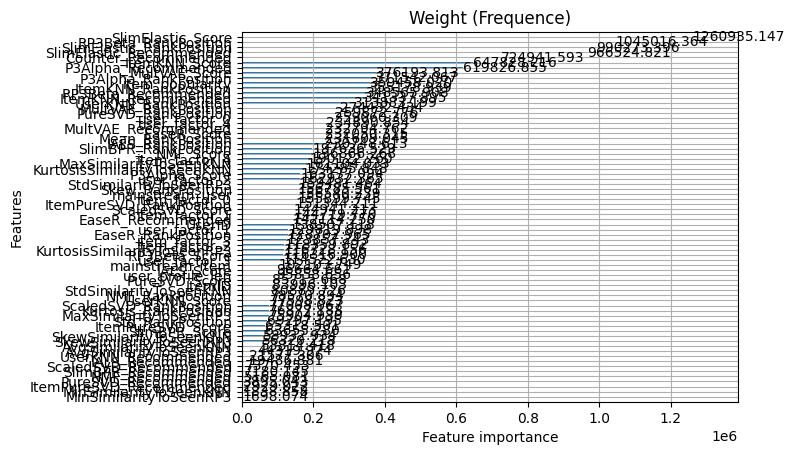

In [65]:
plot_importance(LGBM_model, importance_type='gain', title='Weight (Frequence)')

In [66]:
recommender_item = ItemKNNCFRecommender(URM_all)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_all)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_all)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_all)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_all)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_pure_svd_item = PureSVDItemRecommender(URM_all)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_all)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_all.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_all)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_all.zip')

recommender_slim = SLIMElasticNetRecommender(URM_all)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_all.zip')

recommender_slim_recall = SLIMElasticNetRecommender(URM_all)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_all.zip')

recommender_ease_r = EASE_R_Recommender(URM_all)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_all.zip')

recommender_ials = IALSRecommender(URM_all)
recommender_ials.load_model('/kaggle/working/', 'ials_all.zip')

recommender_vae = MultVAERecommender(URM_all)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_all')

# recommender_als = ALSImplicitRecommender(URM_all)
# recommender_als.load_model('/kaggle/working/', 'als_all.npz')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_all, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Similarity column 22347 (100.0%), 4104.00 column/sec. Elapsed time 5.45 sec
UserKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Similarity column 13024 (100.0%), 3854.62 column/sec. Elapsed time 3.38 sec
RP3betaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
RP3betaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2303.67 column/sec. Elapsed time 9.70 sec
P3alphaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
P3alphaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 2575.49 column/sec. Elapsed time 8.68 sec
PureSVDRecommender: URM Detected 386 ( 3.0%) users with no inter

In [67]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    # 'ALS': recommender_als
}

In [68]:
cutoff = 50
n_users, n_items = URM_all.shape

prediction_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
prediction_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    prediction_dataframe.loc[user_id, "ItemID"] = recommendations
    
prediction_dataframe = prediction_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = prediction_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        prediction_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        prediction_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        prediction_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[prediction_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[prediction_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

prediction_dataframe = prediction_dataframe.reset_index()
prediction_dataframe = prediction_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in prediction_dataframe.columns if col.endswith('_Recommended')]
prediction_dataframe['Counter_Recommended'] = prediction_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in prediction_dataframe.columns if col.endswith('_RankPosition')]
prediction_dataframe['Mean_RankPosition'] = prediction_dataframe[position_columns].mean(axis=1)
prediction_dataframe['Std_RankPosition'] = prediction_dataframe[position_columns].std(axis=1)
prediction_dataframe['Skew_RankPosition'] = prediction_dataframe[position_columns].skew(axis=1)
prediction_dataframe['Kurtosis_RankPosition'] = prediction_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_all).indptr)
item_popularity = item_popularity / np.max(item_popularity)
prediction_dataframe['item_popularity'] = item_popularity[prediction_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_all).indptr)
user_popularity = user_popularity / np.max(user_popularity)
prediction_dataframe['user_profile_len'] = user_popularity[prediction_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_all.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
prediction_dataframe['mainstream_user'] = mainstream_user[prediction_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_all.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
prediction_dataframe['mainstream_item'] = mainstream_item[prediction_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

prediction_dataframe = prediction_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
prediction_dataframe = prediction_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
prediction_dataframe = prediction_dataframe.sort_values(by='UserID')

prediction_dataframe["UserID"] = prediction_dataframe["UserID"].astype(int)
prediction_dataframe["ItemID"] = prediction_dataframe["ItemID"].astype(int)
prediction_dataframe

/tmp/ipykernel_20/1139215485.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,100,0.999999,0.0,1.0,0.419887,5.0,1.0,0.786014,1.0,...,0.045669,0.010442,0.052225,-0.058731,0.022079,0.005573,0.000276,0.007794,-0.010626,-0.001530
27,0,111,0.082615,73.0,0.0,0.107988,15.0,0.0,0.000000,7415.0,...,0.040914,-0.012057,0.014528,-0.047855,-0.023098,0.005573,0.000276,0.007794,-0.010626,-0.001530
28,0,215,0.180754,23.0,0.0,0.010770,1622.0,0.0,0.085517,21.0,...,0.035591,0.015862,-0.019037,0.043913,0.006133,0.005573,0.000276,0.007794,-0.010626,-0.001530
29,0,1082,0.257622,16.0,0.0,0.025246,401.0,0.0,0.088188,20.0,...,0.009403,-0.015196,0.006102,0.006966,-0.003834,0.005573,0.000276,0.007794,-0.010626,-0.001530
30,0,1337,0.235539,18.0,0.0,0.007136,3644.0,0.0,0.064524,39.0,...,0.008009,-0.013008,0.019273,0.015060,0.043675,0.005573,0.000276,0.007794,-0.010626,-0.001530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651189,13023,1238,0.097473,58.0,0.0,0.442709,21.0,0.0,0.073992,64.0,...,0.006622,-0.016999,0.013130,0.007500,0.036445,0.009693,-0.007923,-0.000422,0.004503,0.023066
651150,13023,732,0.576149,5.0,1.0,0.711712,0.0,1.0,0.773915,2.0,...,0.016157,-0.035325,0.015268,0.016982,0.054950,0.009693,-0.007923,-0.000422,0.004503,0.023066
651180,13023,685,0.047530,102.0,0.0,0.459579,17.0,0.0,0.000000,7209.0,...,0.010855,-0.026114,0.011748,0.007983,0.029280,0.009693,-0.007923,-0.000422,0.004503,0.023066
651153,13023,2119,0.660220,2.0,1.0,0.547857,5.0,1.0,0.593510,6.0,...,0.004605,-0.013688,0.006540,0.004982,0.021528,0.009693,-0.007923,-0.000422,0.004503,0.023066


In [69]:
recommender = LightGBMRerankerRecommender(URM_all, LGBM_model, prediction_dataframe)

In [70]:
recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10, return_scores=False)
recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
display(submission_df.head())

submission_df.to_csv('/kaggle/working/submission_lightgbm.csv', index=False)

,user_id,item_list
0,1,101 36 506 123 403 515 694 1546 977 52
1,2,1095 12 1522 47 656 2 3176 102 50 11
2,3,59 259 857 4252 536 239 584 648 9 956
3,4,28 249 50 7 139 5 171 146 1 314
4,5,1570 5138 77 131 170 471 1220 1511 95 4
